In [186]:
# Basic libraries #
import math
import pandas as pd
import numpy as np
import os

# Vizualization Libraries #
import matplotlib.pyplot as plt
import seaborn as sns

# Classification Algorithm #
from catboost import CatBoostClassifier
from sklearn.metrics import * 
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint

In [179]:
df = pd.read_csv("C:\\Users\\Admin\\Downloads\\Bankloan_Cleanedv1.csv")


In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       680 non-null    float64
 1   employ    700 non-null    int64  
 2   address   700 non-null    int64  
 3   income    663 non-null    float64
 4   debtinc   700 non-null    float64
 5   creddebt  700 non-null    float64
 6   othdebt   700 non-null    float64
 7   ed        680 non-null    float64
 8   default   700 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 49.3 KB


In [181]:
df.shape

(700, 9)

In [182]:
df.isnull().sum()

age         20
employ       0
address      0
income      37
debtinc      0
creddebt     0
othdebt      0
ed          20
default      0
dtype: int64

In [183]:
df = df.dropna()

In [184]:
df.shape

(625, 9)

In [185]:
df['default'].value_counts()

0    463
1    162
Name: default, dtype: int64

In [188]:
df.describe()

,age,employ,address,income,debtinc,creddebt,othdebt,ed,default
count,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000
mean,34.848000,8.352000,8.240000,45.635200,10.238880,1.543640,3.020191,1.720000,0.259200
std,8.011666,6.741871,6.801678,37.886318,6.754012,2.146588,3.156205,0.921607,0.438547
min,20.000000,0.000000,0.000000,14.000000,0.400000,0.011696,0.045584,1.000000,0.000000
25%,28.000000,3.000000,3.000000,24.000000,5.100000,0.369974,1.048346,1.000000,0.000000
50%,34.000000,7.000000,7.000000,34.000000,8.700000,0.849024,1.995136,1.000000,0.000000
75%,40.000000,12.000000,12.000000,54.000000,14.000000,1.875168,3.946800,2.000000,1.000000
max,56.000000,31.000000,34.000000,446.000000,41.300000,20.561310,27.033600,5.000000,1.000000


In [189]:
df.corr()

,age,employ,address,income,debtinc,creddebt,othdebt,ed,default
age,1.000000,0.538428,0.593904,0.486902,0.006578,0.312636,0.355244,0.051526,-0.136551
employ,0.538428,1.000000,0.327991,0.618661,-0.040426,0.408735,0.420766,-0.115395,-0.286202
address,0.593904,0.327991,1.000000,0.324901,-0.000033,0.224946,0.228101,0.078997,-0.167560
income,0.486902,0.618661,0.324901,1.000000,-0.042549,0.579024,0.631127,0.256390,-0.072813
debtinc,0.006578,-0.040426,-0.000033,-0.042549,1.000000,0.481652,0.558695,0.007828,0.386527
creddebt,0.312636,0.408735,0.224946,0.579024,0.481652,1.000000,0.651542,0.104226,0.241050
othdebt,0.355244,0.420766,0.228101,0.631127,0.558695,0.651542,1.000000,0.168959,0.132470
ed,0.051526,-0.115395,0.078997,0.256390,0.007828,0.104226,0.168959,1.000000,0.096590
default,-0.136551,-0.286202,-0.167560,-0.072813,0.386527,0.241050,0.132470,0.096590,1.000000


In [192]:
cat = CatBoostClassifier(verbose=0, iterations=100, learning_rate=0.03, depth=6)
cat.fit(X_train, y_train)
cv_scores = cross_val_score(cat, X, y, cv=5, scoring='roc_auc')
y_pred = cat.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred)
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print(f'Cross-validation AUC score: {cv_mean:.4f} ± {cv_std:.4f}')
print(f'Test AUC score: {auc_score:.4f}')

Cross-validation AUC score: 0.8170 ± 0.0485
Test AUC score: 0.6230


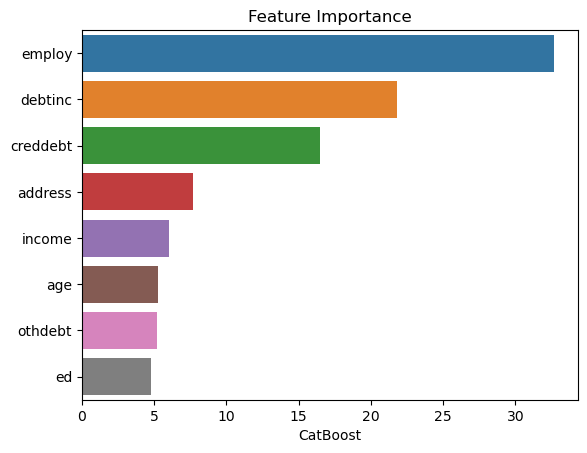

In [193]:
feature_imp = pd.Series(cat.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('CatBoost')
plt.title("Feature Importance")
plt.show()

In [194]:
def thresh_test(author, model_name, model, X_test, y_test):

    threshholds = np.arange(0.3, 0.09, -0.01)
    matrix = []
    
    for i in threshholds:
        y_pred = np.where(model.predict_proba(X_test)[:, 1] > i, 1, 0)
        conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
        matrix.append([author, model_name, i, roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]), 
                    accuracy_score(y_test, y_pred), conf_matrix[1][1], conf_matrix[0][1], conf_matrix[0][0], conf_matrix[1][0]])
    
    
    output = pd.DataFrame(matrix, columns=['Author', 'Model', 'Threshold', 'ROC_AUC', 'Accuracy', 'TN', 'FP', 'TP', 'FN'])
    
    
    return output

In [195]:
thresh_test('Madina', 'CatBoost', cat, X_test, y_test)

,Author,Model,Threshold,ROC_AUC,Accuracy,TN,FP,TP,FN
0,Madina,CatBoost,0.30,0.783389,0.704,32,25,56,12
1,Madina,CatBoost,0.29,0.783389,0.712,34,26,55,10
2,Madina,CatBoost,0.28,0.783389,0.688,35,30,51,9
3,Madina,CatBoost,0.27,0.783389,0.680,35,31,50,9
4,Madina,CatBoost,0.26,0.783389,0.688,36,31,50,8
5,Madina,CatBoost,0.25,0.783389,0.688,36,31,50,8
6,Madina,CatBoost,0.24,0.783389,0.680,36,32,49,8
7,Madina,CatBoost,0.23,0.783389,0.680,37,33,48,7
8,Madina,CatBoost,0.22,0.783389,0.680,37,33,48,7
9,Madina,CatBoost,0.21,0.783389,0.696,39,33,48,5


In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

bankloan_df = pd.read_csv('Bankloan_Cleanedv1 .csv')
bankloan_df_cleaned = bankloan_df.dropna()

X = bankloan_df_cleaned.drop(columns=['default'])
y = bankloan_df_cleaned['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

catboost_model = CatBoostClassifier(verbose=0)

param_grid = {
    'iterations': [100, 200, 500],  # number of boosting iterations
    'depth': [4, 6, 8],  # depth of the tree
    'learning_rate': [0.01, 0.1, 0.2],  # learning rate
    'l2_leaf_reg': [1, 3, 5, 7],  # L2 regularization term
    'bagging_temperature': [0.0, 0.5, 1.0],  # controls overfitting 
}

grid_search = GridSearchCV(catboost_model, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred)

print(f"Best hyperparameters: {best_params}")
print(f"Test AUC score: {auc_score:.4f}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best hyperparameters: {'bagging_temperature': 0.0, 'depth': 8, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Test AUC score: 0.6016


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

# Load and clean the dataset
bankloan_df = pd.read_csv('Bankloan_Cleanedv1 .csv')
bankloan_df_cleaned = bankloan_df.dropna()

# Feature engineering: Create new features using .loc to avoid the warning
bankloan_df_cleaned.loc[:, 'creddebt_to_income'] = bankloan_df_cleaned['creddebt'] / bankloan_df_cleaned['income']
bankloan_df_cleaned.loc[:, 'total_debt_to_income'] = (bankloan_df_cleaned['creddebt'] + bankloan_df_cleaned['othdebt']) / bankloan_df_cleaned['income']

# Separate features (X) and target (y)
X = bankloan_df_cleaned.drop(columns=['default'])
y = bankloan_df_cleaned['default']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# Initialize the CatBoost classifier with class weights
catboost_model = CatBoostClassifier(verbose=0, class_weights=class_weights_dict)

# Define an expanded hyperparameter grid
param_grid = {
    'iterations': [500, 1000],  # More iterations for better learning
    'depth': [6, 8, 10],  # Higher tree depth to capture more complexity
    'learning_rate': [0.01, 0.05],  # Lower learning rate to fine-tune
    'l2_leaf_reg': [1, 3, 5, 7],  # Regularization to avoid overfitting
    'bagging_temperature': [0.0, 0.5, 1.0],  # Randomness for bagging
    'border_count': [32, 64, 128],  # Number of splits for categorical features
}

# Grid Search with 5-fold cross-validation and ROC AUC scoring
grid_search = GridSearchCV(catboost_model, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict on the test data and calculate AUC score
y_pred = best_model.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred)

# Output the best hyperparameters and AUC score
print(f"Best hyperparameters: {best_params}")
print(f"Test AUC score: {auc_score:.4f}")


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/var/folders/pc/zckxtwks0pz6h8p8r29tkpg00000gn/T/ipykernel_86916/35837278.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bankloan_df_cleaned.loc[:, 'creddebt_to_income'] = bankloan_df_cleaned['creddebt'] / bankloan_df_cleaned['income']
/var/folders/pc/zckxtwks0pz6h8p8r29tkpg00000gn/T/ipykernel_86916/35837278.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bankloan_df_cleaned.loc[:, 'total_debt_to_income'] = (bankloan_df_cleaned['creddebt'] + bankloan_df_cleaned['othdebt']) / bankloan_df_cleaned['

Best hyperparameters: {'bagging_temperature': 0.0, 'border_count': 64, 'depth': 10, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.01}
Test AUC score: 0.6554


In [7]:
pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 267.0 kB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

# Load and clean the dataset
bankloan_df = pd.read_csv('Bankloan_Cleanedv1 .csv')
bankloan_df_cleaned = bankloan_df.dropna().copy()  # Explicitly create a copy to avoid warnings

# Feature engineering: Create new features
bankloan_df_cleaned['creddebt_to_income'] = bankloan_df_cleaned['creddebt'] / bankloan_df_cleaned['income']
bankloan_df_cleaned['total_debt_to_income'] = (bankloan_df_cleaned['creddebt'] + bankloan_df_cleaned['othdebt']) / bankloan_df_cleaned['income']

# Separate features (X) and target (y)
X = bankloan_df_cleaned.drop(columns=['default'])
y = bankloan_df_cleaned['default']

# Handle class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize the CatBoost and XGBoost classifiers with class weights
catboost_model = CatBoostClassifier(verbose=0)
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define an expanded hyperparameter grid for both models
param_grid_catboost = {
    'iterations': [500, 1000],
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0.0, 0.5, 1.0],
    'border_count': [32, 64, 128],
}

param_grid_xgboost = {
    'n_estimators': [500, 1000],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Perform grid search for CatBoost
grid_search_catboost = GridSearchCV(catboost_model, param_grid=param_grid_catboost, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)
grid_search_catboost.fit(X_train, y_train)
best_params_catboost = grid_search_catboost.best_params_
best_model_catboost = grid_search_catboost.best_estimator_

# Perform grid search for XGBoost
grid_search_xgboost = GridSearchCV(xgboost_model, param_grid=param_grid_xgboost, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)
grid_search_xgboost.fit(X_train, y_train)
best_params_xgboost = grid_search_xgboost.best_params_
best_model_xgboost = grid_search_xgboost.best_estimator_

# Predict and evaluate both models on test data
y_pred_catboost = best_model_catboost.predict(X_test)
y_pred_xgboost = best_model_xgboost.predict(X_test)

auc_score_catboost = roc_auc_score(y_test, y_pred_catboost)
auc_score_xgboost = roc_auc_score(y_test, y_pred_xgboost)

# Output the best hyperparameters and AUC score
print(f"Best hyperparameters for CatBoost: {best_params_catboost}")
print(f"Test AUC score for CatBoost: {auc_score_catboost:.4f}")

print(f"Best hyperparameters for XGBoost: {best_params_xgboost}")
print(f"Test AUC score for XGBoost: {auc_score_xgboost:.4f}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:47:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:47:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:47:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:47:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt

Best hyperparameters for CatBoost: {'bagging_temperature': 0.0, 'border_count': 128, 'depth': 10, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
Test AUC score for CatBoost: 0.8459
Best hyperparameters for XGBoost: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1000, 'subsample': 0.7}
Test AUC score for XGBoost: 0.8459


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
